# Debugging and sanity checks of f4 ration Nea. estimates

In [1]:
suppressMessages({

library(tidyverse)
library(admixr)

source("../R/utils.R")

})

In [2]:
library(devtools)
reload(inst("admixr"))

Reloading installed admixr


In [3]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

<br><br><br>
# Old vs new processing of the Altai data

## Old Altai

In [4]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged")

In [5]:
s <- c("UstIshim", filter(samples, pop == "WestEurasia")$name)

### Use two individual f4 statistics to calculate the f4 ratio of Nea. ancestry

In [6]:
num_old <- qpDstat(W=s, X="Mbuti", Y="Altai", Z="Chimp",
                   prefix=EIGENSTRAT, dir_name="../admixtools/", f4mode=TRUE)

In [7]:
den_old <- qpDstat(W="new_Vindija", X="Mbuti", Y="Altai", Z="Chimp",
               prefix=EIGENSTRAT, dir_name="../admixtools/", f4mode=TRUE)

In [8]:
f4a_old <- mutate(num_old, alpha=Dstat/den_old$Dstat, name=W) %>% rename(admixtools_a=alpha)

### Merge this "manual" f4 ratio data.frame with the `qpF4ratio` results for the same setup

In [9]:
f4b_old  <- qpF4ratio(X=s, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                      prefix=EIGENSTRAT, dir_name="../admixtools") %>%
    rename(admixtools_b=alpha) %>% mutate(name=X)

### Plot the correlation of both

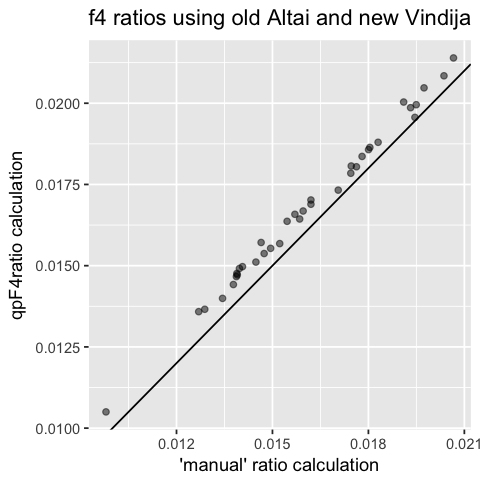

In [84]:
options(repr.plot.width=4, repr.plot.height=4)

inner_join(f4a_old, f4b_old, by="name") %>%
ggplot(aes(admixtools_a,  admixtools_b)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    labs(title="f4 ratios using old Altai and new Vindija",
         x="'manual' ratio calculation", y="qpF4ratio calculation")

## New Altai

In [11]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

In [12]:
s <- c("UstIshim", filter(samples, ! pop %in% c("EMH", "Oceania"))$name)

### Use two individual f4 statistics to calculate the f4 ratio of Nea. ancestry

In [13]:
num <- qpDstat(W=s, X="Mbuti", Y="new_Altai", Z="Chimp",
               prefix=EIGENSTRAT, dir_name="../admixtools/", f4mode=TRUE)

In [14]:
den <- qpDstat(W="new_Vindija", X="Mbuti", Y="new_Altai", Z="Chimp",
               prefix=EIGENSTRAT, dir_name="../admixtools/", f4mode=TRUE)

In [15]:
f4a <- mutate(num, alpha=Dstat/den$Dstat, name=W) %>% rename(admixtools_a=alpha)

### Merge this "manual" f4 ratio data.frame with the `qpF4ratio` results for the same setup

In [13]:
f4b  <- qpF4ratio(X=s, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, dir_name="../admixtools") %>%
    rename(admixtools_b=alpha) %>% mutate(name=X)

### Plot the correlation of both

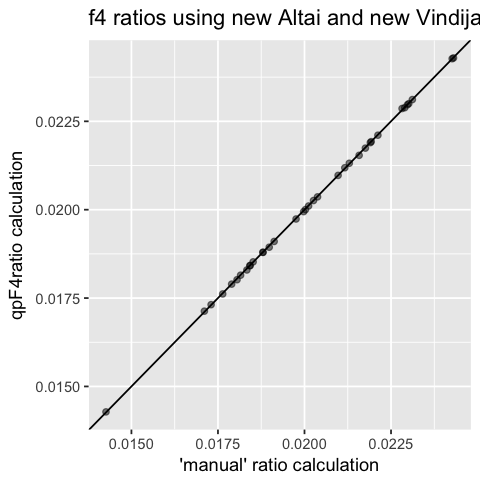

In [85]:
options(repr.plot.width=4, repr.plot.height=4)

inner_join(f4a, f4b, by="name") %>%
ggplot(aes(admixtools_a,  admixtools_b)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    labs(title="f4 ratios using new Altai and new Vindija",
         x="'manual' ratio calculation", y="qpF4ratio calculation")

## My f4 ratios on Steffi's data - intersect

In [4]:
EIGENSTRAT_DIR <- "../raw_data/merged_vcfs/"
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "steffi")

EIGENSTRAT_SUBSET <- paste0(EIGENSTRAT, "_subset")

In [5]:
s <- c("Ust_Ishim", filter(samples, ! pop %in% c("EMH", "Oceania"))$name)

In [6]:
EIGENSTRAT_SUBSET

[1] "../raw_data/merged_vcfs/steffi_subset"

In [7]:
subset_sites(EIGENSTRAT, EIGENSTRAT_SUBSET, pos_file="../raw_data/eigenstrat_all/sites.pos")

Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer()
)
Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)
Joining, by = c("chrom", "pos")


[1] TRUE

### Merge this "manual" f4 ratio data.frame with the `qpF4ratio` results for the same setup

In [9]:
f4_steffi_subset <- qpF4ratio(X=s, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_SUBSET,
                         dir_name="../admixtools") %>%
    rename(steffi_subset=alpha) %>% mutate(name=X)

### Plot the correlation of both

Run on the exact subset:

Joining, by = "name"


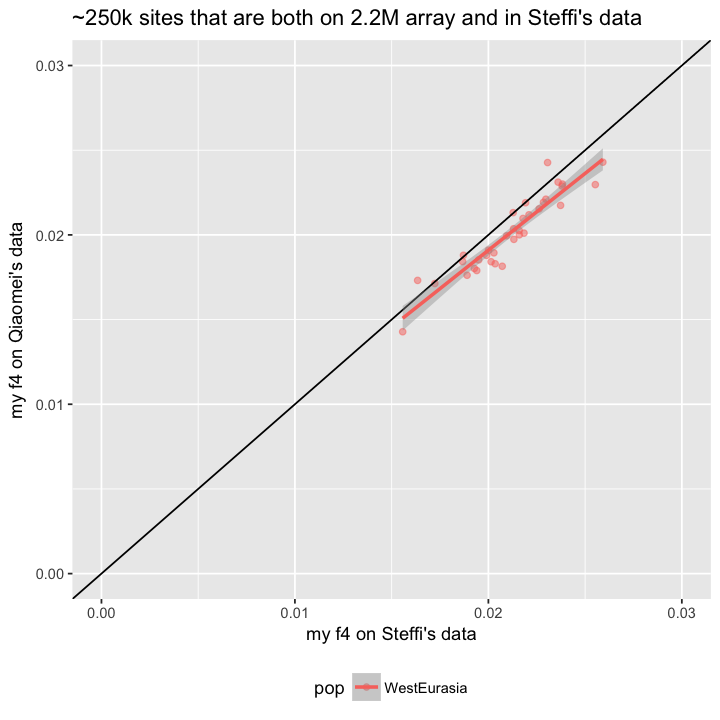

In [66]:
options(repr.plot.width=6, repr.plot.height=6)

inner_join(f4_steffi_subset, f4b, by="name") %>% inner_join(samples) %>% filter(pop == "WestEurasia") %>% 
ggplot(aes(steffi_subset,  admixtools_b, color=pop)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0, 0.03), y=c(0, 0.03)) +
    labs(title="~250k sites that are both on 2.2M array and in Steffi's data",
         x="my f4 on Steffi's data", y="my f4 on Qiaomei's data") +
    theme(legend.position="bottom")

In [72]:
steffi_f4 <- read_table2("../raw_data/steffi/results_usti_test_array/f4_ratios") %>% mutate(set="array") %>% 
    filter(pop3 == "Altai", pop2 == "Mbuti") %>% 
    mutate(pop1=ifelse(pop1 == "Ust_Ishim", "UstIshim", pop1)) %>% 
    rename(name=pop1, steffi_f4=f4_ratio)

Parsed with column specification:
cols(
  pop1 = col_character(),
  pop2 = col_character(),
  pop3 = col_character(),
  abba = col_double(),
  baba = col_double(),
  f4 = col_double(),
  f4_ratio = col_double(),
  se = col_double(),
  z = col_double(),
  denom_nean = col_character()
)


Joining, by = "name"


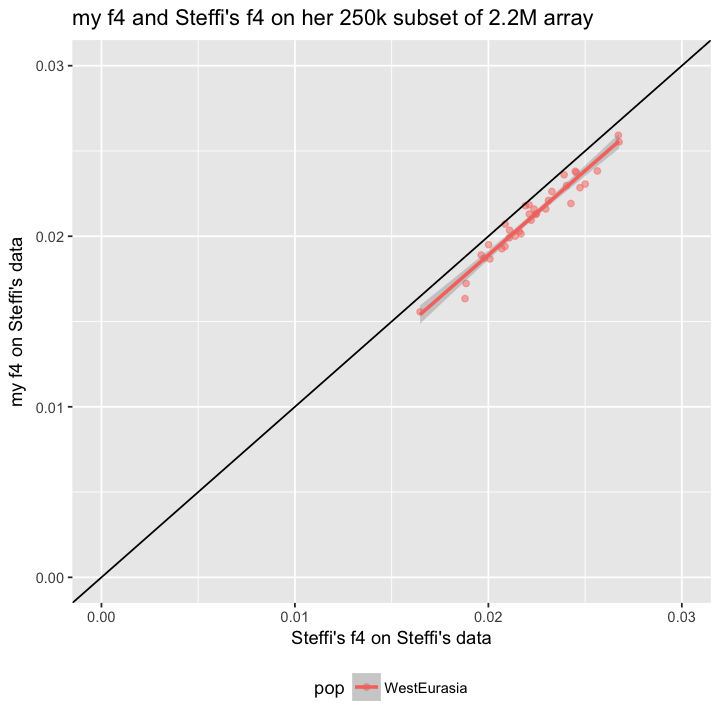

In [79]:
options(repr.plot.width=6, repr.plot.height=6)

inner_join(steffi_f4, f4_steffi_subset, by="name") %>% inner_join(samples) %>% filter(pop == "WestEurasia") %>% 
ggplot(aes(steffi_f4, steffi_subset, color=pop)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0, 0.03), y=c(0, 0.03)) +
    labs(title="my f4 and Steffi's f4 on her 250k subset of 2.2M array",
         y="my f4 on Steffi's data", x="Steffi's f4 on Steffi's data") +
    theme(legend.position="bottom")

# calculate my f4 on the 250k subset but FROM QIAOMEI'S ORIGINAL DATA

## My f4 ratios on Steffi's data - complement

In [20]:
EIGENSTRAT_DIR <- "../raw_data/merged_vcfs/"
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "steffi")

EIGENSTRAT_SUBSET <- paste0(EIGENSTRAT, "_complement")

In [21]:
s <- c("Ust_Ishim", filter(samples, ! pop %in% c("EMH", "Oceania"))$name)

In [22]:
EIGENSTRAT_SUBSET

[1] "../raw_data/merged_vcfs/steffi_complement"

In [24]:
subset_sites(EIGENSTRAT, EIGENSTRAT_SUBSET, pos_file="../raw_data/eigenstrat_all/sites.pos", complement=TRUE)

Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer()
)
Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)
Joining, by = c("chrom", "pos")


[1] TRUE

### Merge this "manual" f4 ratio data.frame with the `qpF4ratio` results for the same setup

In [26]:
f4_steffi_complement <- qpF4ratio(X=s, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_SUBSET,
                         dir_name="../admixtools") %>%
    rename(steffi_complement=alpha) %>% mutate(name=X)

### Plot the correlation of both

Run on the exact subset:

Joining, by = "name"


Joining, by = "name"


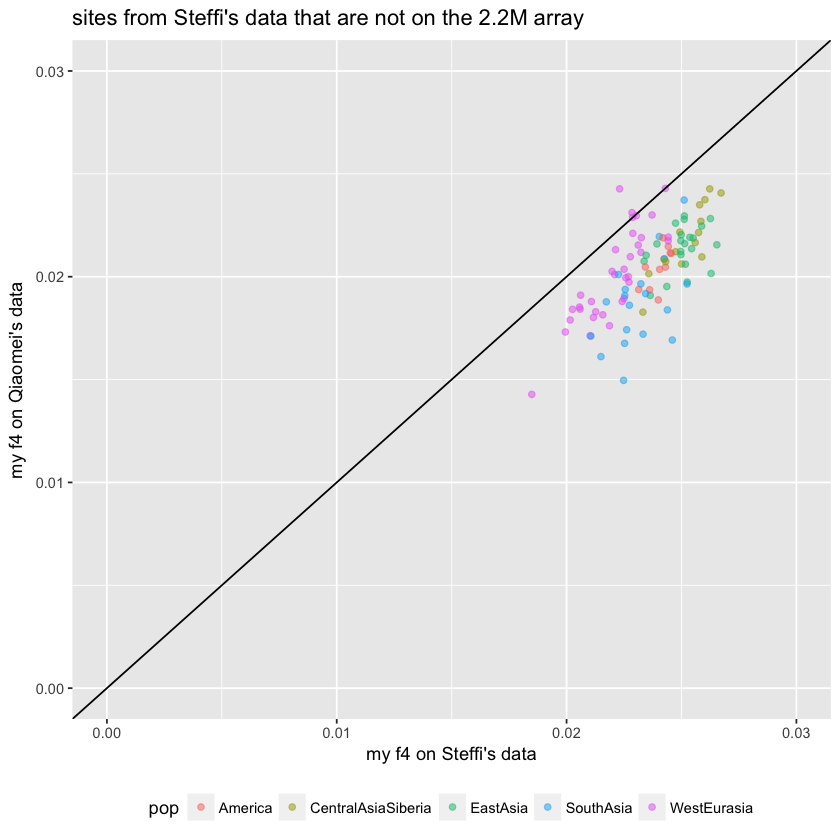

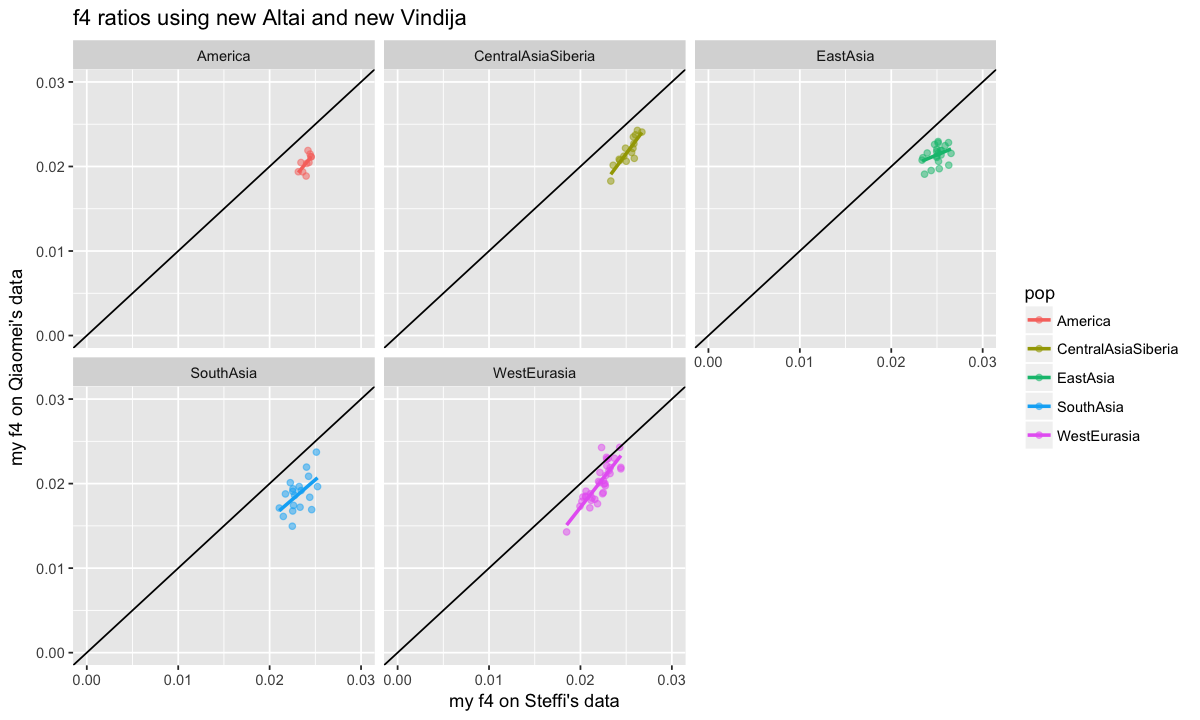

In [40]:
options(repr.plot.width=7, repr.plot.height=7)

inner_join(f4_steffi_complement, f4b, by="name") %>% inner_join(samples) %>% 
ggplot(aes(steffi_complement,  admixtools_b, color=pop)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    coord_cartesian(x=c(0, 0.03), y=c(0, 0.03)) +
    labs(title="sites from Steffi's data that are not on the 2.2M array",
         x="my f4 on Steffi's data", y="my f4 on Qiaomei's data") +
    theme(legend.position="bottom")

options(repr.plot.width=10, repr.plot.height=6)

inner_join(f4_steffi_complement, f4b, by="name") %>% inner_join(samples) %>% 
ggplot(aes(steffi_complement,  admixtools_b, color=pop)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    facet_wrap(~ pop) +
    geom_smooth(method="lm", se=FALSE) +
    coord_cartesian(x=c(0, 0.03), y=c(0, 0.03)) +
    labs(title="f4 ratios using new Altai and new Vindija",
         x="my f4 on Steffi's data", y="my f4 on Qiaomei's data")

## Comparison with Steffi's f4 ratios

In [80]:
load("../RData/nea_estimates.RData")

In [81]:
suppressMessages({

steffi_df <- bind_rows(list(
    read_table2("../raw_data/steffi/results_usti_test/f4_ratios") %>% mutate(set="all"),
    read_table2("../raw_data/steffi/results_usti_test_array/f4_ratios") %>% mutate(set="array")
    )) %>% 
    filter(pop3 == "Altai", pop2 == "Mbuti") %>% 
    mutate(pop1=ifelse(pop1 == "Ust_Ishim", "UstIshim", pop1)) %>% 
    left_join(samples, by=c("pop1"="name")) %>%
    rename(name=pop1)

})

steffi_nea <- steffi_df %>% select(name, f4_ratio, set, pop) %>% spread(set, f4_ratio) %>%
    rename(steffi_all=all, steffi_array=array)

In [82]:
steffi_nea %>% head

name,pop,steffi_all,steffi_array
Abkhasian,WestEurasia,0.01993022,0.02001503
Adygei,WestEurasia,0.02330924,0.02563313
Albanian,WestEurasia,0.02408386,0.02671752
Aleut,CentralAsiaSiberia,0.02523005,0.02532569
Altaian,CentralAsiaSiberia,0.02613542,0.02702200
Ami,EastAsia,0.02532708,0.02458556


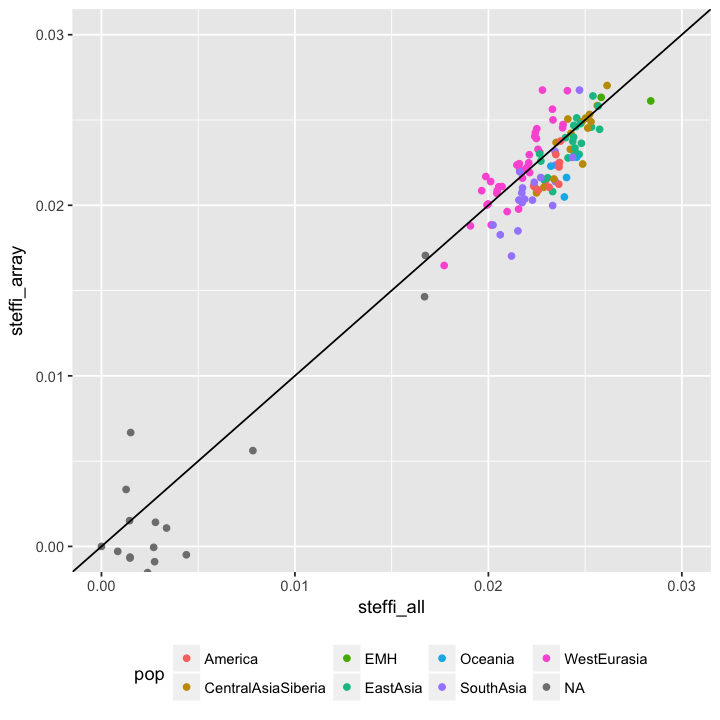

In [91]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res=120)

ggplot(steffi_nea, aes(steffi_all, steffi_array, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    theme(legend.position="bottom") + coord_cartesian(x=c(0, 0.03), y=c(0, 0.03))

In [55]:
direct <- all_nea_estimates %>%
    filter(method == "direct") %>%
    select(name, pop, martin_direct=alpha)

f4 <- all_nea_estimates %>%
    filter(method == "qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp") %>%
    select(name, pop, martin_admixtools=alpha)

In [56]:
merged <- inner_join(direct, f4) %>% inner_join(steffi_nea)

Joining, by = c("name", "pop")
Joining, by = c("name", "pop")


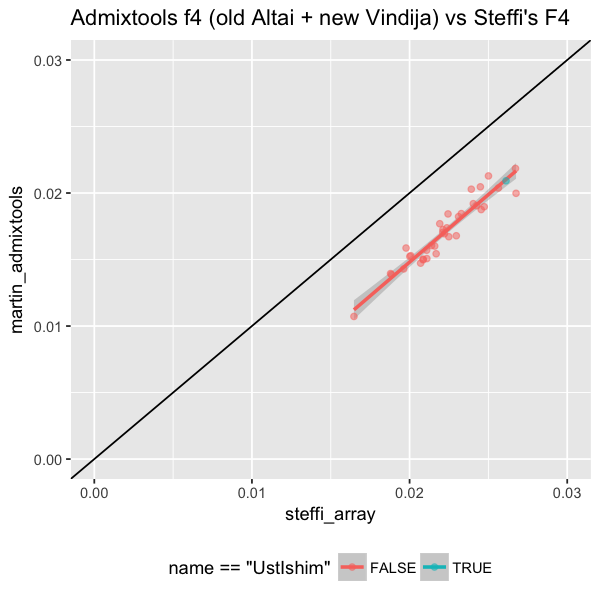

In [51]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=120)

# using Vindja
ggplot(filter(merged, name == "UstIshim" | pop == "WestEurasia"),
       aes(steffi_array, martin_admixtools, color=name == "UstIshim")) +
    geom_smooth(method="lm") +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    xlim(0, 0.03) + ylim(0, 0.03) +
    labs(title="Admixtools f4 (old Altai + new Vindija) vs Steffi's F4") +
    theme(legend.position="bottom")

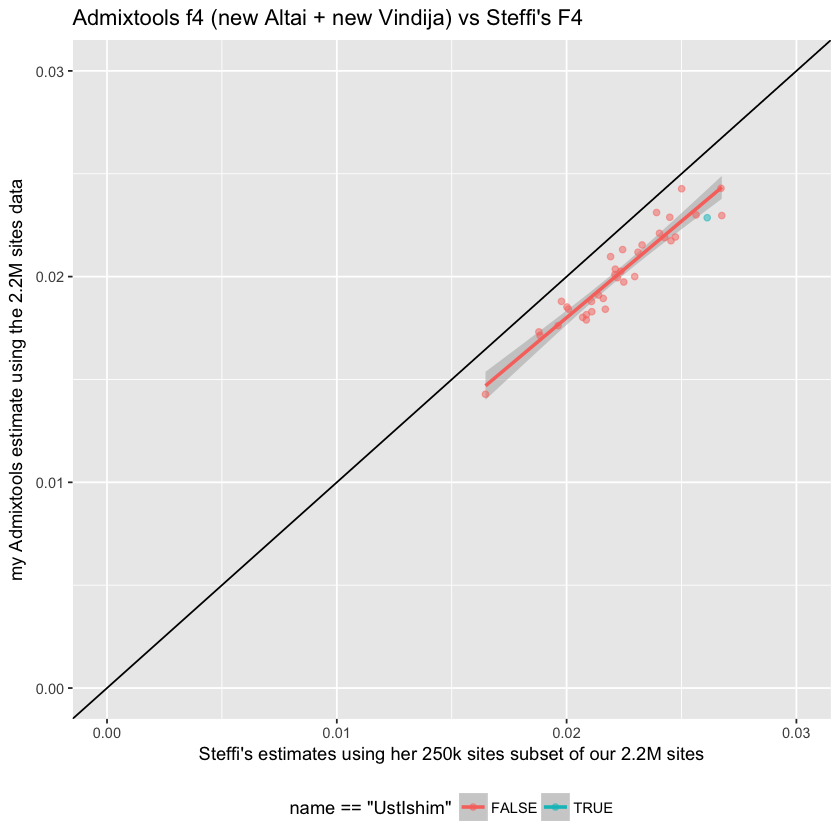

In [65]:
options(repr.plot.width=7, repr.plot.height=7, repr.plot.res=120)

# using Vindja
ggplot(filter(merged, name == "UstIshim" | pop == "WestEurasia"),
       aes(steffi_array, martin_admixtools, color=name == "UstIshim")) +
    geom_smooth(method="lm") +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    xlim(0, 0.03) + ylim(0, 0.03) +
    labs(title="Admixtools f4 (new Altai + new Vindija) vs Steffi's F4",
        x="Steffi's estimates using her 250k sites subset of our 2.2M sites",
        y="my Admixtools estimate using the 2.2M sites data") +
    theme(legend.position="bottom")

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

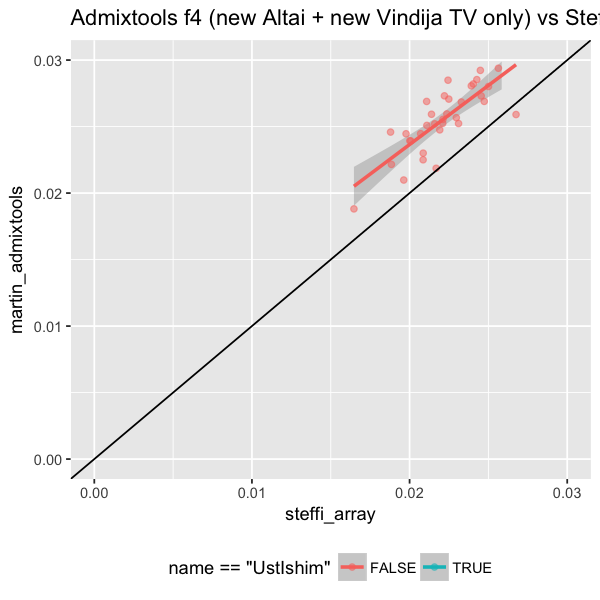

In [63]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=120)

# using Vindja
ggplot(filter(merged, name == "UstIshim" | pop == "WestEurasia"),
       aes(steffi_array, martin_admixtools, color=name == "UstIshim")) +
    geom_smooth(method="lm") +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    xlim(0, 0.03) + ylim(0, 0.03) +
    labs(title="Admixtools f4 (new Altai + new Vindija TV only) vs Steffi's F4") +
    theme(legend.position="bottom")